# Implicit Differentiation for a High-Entropy Alloy (HEA)

In [1]:
import os
import pickle
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der.systems import BCC_BINARY, get_bcc_alloy_A_delta_B
from lammps_implicit_der import SNAP
from lammps_implicit_der.tools import error_tools, plot_tools

## Generate perturbed Ni-Mo alloy with given by the $\delta$ parameter:

For Ni atoms, $\Theta^{\mathrm{Ni}}$ is fixed. For Mo atoms the potential is setup as follows:

$$\Theta(\delta) = \delta \times \Theta^{\mathrm{Ni}} + (1-\delta) \times \Theta^{\mathrm{Mo}}$$

$$\delta = 0 \rightarrow \Theta(\delta)=\Theta^{\mathrm{Mo}}$$
$$\delta = 1 \rightarrow \Theta(\delta)=\Theta^{\mathrm{Ni}}$$

In this way, at $\delta=0$, we have the 'quasi' Mo atoms. 'Quasi' because the snapparams are taken from the Ni potential.

## True Nickel-Molybdenum random alloy

In [2]:
ncell_x = 2
specie_B_concentration=0.5

In [3]:
bcc_alloy_Ni_Mo = BCC_BINARY(datafile=None,
                            snapcoeff_filename='NiMo.snapcoeff',
                            ncell_x=ncell_x,
                            specie_B_concentration=specie_B_concentration,
                            minimize=True)


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: Ni Mo
                          quadraticflag: 0
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 51 steps
Initial fmax: 4.183e-01, final fmax: 2.396e-09
Initial fnorm: 1.321e+00, final fnorm: 8.923e-09
Number of atoms: 16, largest force value: 2.396e-09, force norm: 8.923e-09


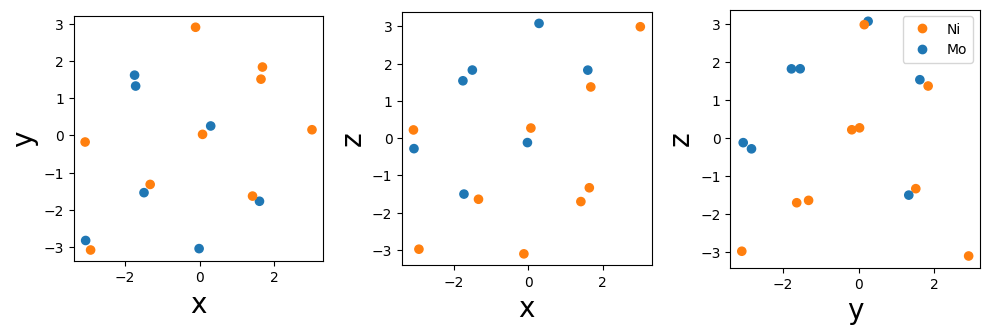

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in bcc_alloy_Ni_Mo.species]
plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plt.tight_layout()
plot_tools.setup_color_legend(axes[2], list(specie_color.values()), bcc_alloy_Ni_Mo.pot.elem_list)
plt.show()

## Quasi-Ni-Mo alloy


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: Ni Mo
                          quadraticflag: 0
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Number of atoms: 16, largest force value: 4.183e-01, force norm: 1.321e+00
Saved SNAP coefficients to ./Ni_delta_Mo.snapcoeff
Saved SNAP parameters to ./Ni_delta_Mo.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log bcc_alloy_tmp.log

Setting SNAP potential

                  SNAP coefficients for: Ni Mo
                          quadraticflag: 0
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R

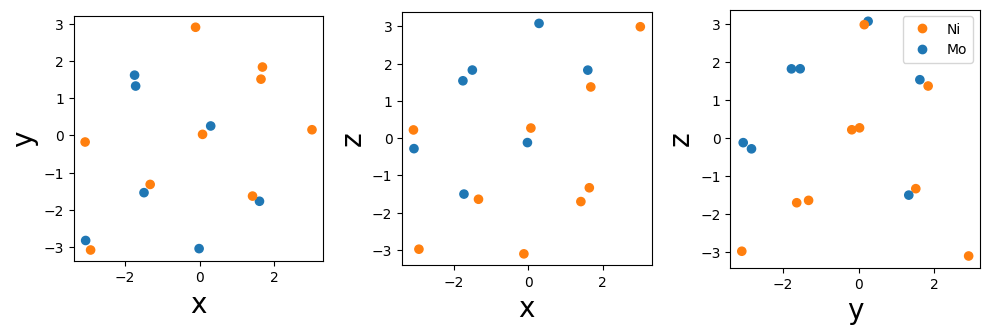

16


In [5]:
# Test the function get_bcc_alloy_A_delta_B: with delta = 0.0 we should get the same structure as above
bcc_alloy_Ni_Mo_test = get_bcc_alloy_A_delta_B(delta=0.0,
                                                ncell_x=ncell_x,
                                                minimize=True,
                                                datafile=None,
                                                specie_B_concentration=specie_B_concentration)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo_test.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plt.tight_layout()
plot_tools.setup_color_legend(axes[2], list(specie_color.values()), bcc_alloy_Ni_Mo_test.pot.elem_list)
plt.show()

print(bcc_alloy_Ni_Mo_test.Natom)

## Perturbed Ni-Mo with $\Theta^{\mathrm{Ni}}$, $\Theta^{\mathrm{Mo}}(\delta)$

In [6]:
# Perturb slightly the parameters
delta = 0.4
bcc_alloy_Ni_Mo_pert = get_bcc_alloy_A_delta_B(delta=delta,
                                               ncell_x=ncell_x,
                                               minimize=True,
                                               datafile=None,
                                               specie_B_concentration=specie_B_concentration)




--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: Ni Mo
                          quadraticflag: 0
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Number of atoms: 16, largest force value: 4.183e-01, force norm: 1.321e+00
Overwriting ./Ni_delta_Mo.snapcoeff
Overwriting ./Ni_delta_Mo.snapparam
Saved SNAP coefficients to ./Ni_delta_Mo.snapcoeff
Saved SNAP parameters to ./Ni_delta_Mo.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log bcc_alloy_tmp.log

Setting SNAP potential

                  SNAP coefficients for: Ni Mo
                          quadraticflag: 0
 Number of parameters

In [7]:
# Compute the implicit derivative with respect to Mo parameters
method = 'inverse'
#method='energy'
dX_dTheta = bcc_alloy_Ni_Mo.implicit_derivative(method=method)

Computing the Hessian...


Hessian (full): 100%|██████████| 48/48 [00:00<00:00, 149.75it/s]


In [8]:
Theta_Mo_pert = bcc_alloy_Ni_Mo_pert.pot.Theta_dict['Mo']['Theta'].copy()
Theta_Mo = bcc_alloy_Ni_Mo.pot.Theta_dict['Mo']['Theta'].copy()

dTheta = Theta_Mo_pert - Theta_Mo

In [9]:
# Predicted coordinate perturbation
dX_pred = dTheta @ dX_dTheta

X_pred = bcc_alloy_Ni_Mo.minimum_image(bcc_alloy_Ni_Mo.X_coord + dX_pred)

In [10]:
# True change
X_true = bcc_alloy_Ni_Mo_pert.X_coord.copy()
dX_true = bcc_alloy_Ni_Mo.minimum_image(X_true - bcc_alloy_Ni_Mo.X_coord)

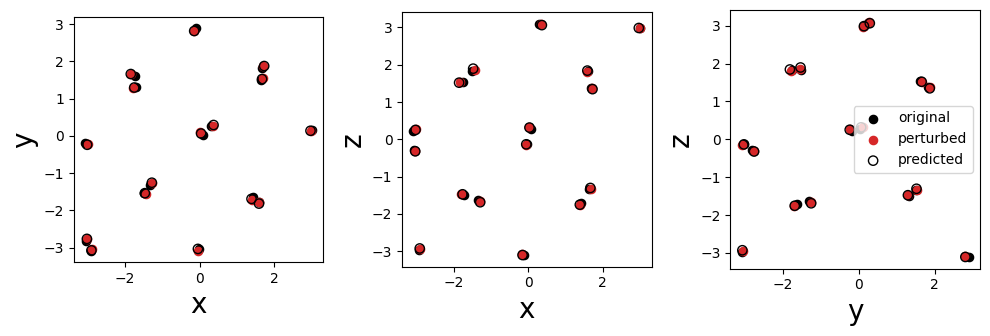

In [11]:
# Plot the coordinates
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in bcc_alloy_Ni_Mo.species]

color_list = ['black','tab:orange', 'tab:blue', 'black']
label_list = ['original', 'Ni', '$\delta$Mo', 'from dX/dTheta']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c='black', s=35, label='original')
plot_tools.plot_coords(axes, X_true.reshape(-1, 3), c='tab:red', s=35, label='perturbed')
plot_tools.plot_coords(axes, X_pred.reshape(-1, 3), s=45, label='predicted', facecolors='none', edgecolors='black', marker='o')
plt.tight_layout()
plt.show()

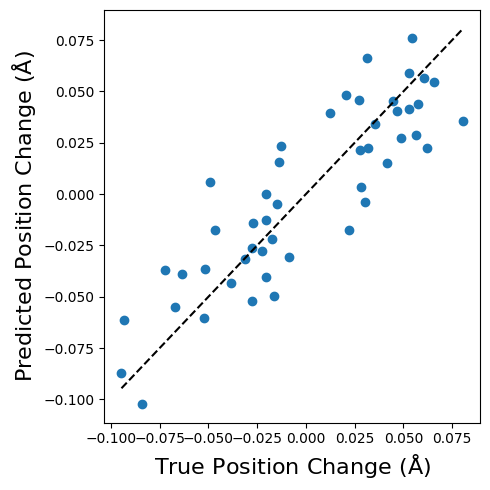

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], 'k--')
fsize = 16
ax.set_xlabel(r'True Position Change ($\mathrm{\AA}$)', fontsize=fsize)
ax.set_ylabel(r'Predicted Position Change ($\mathrm{\AA}$)', fontsize=fsize)
plt.tight_layout()
plt.show()

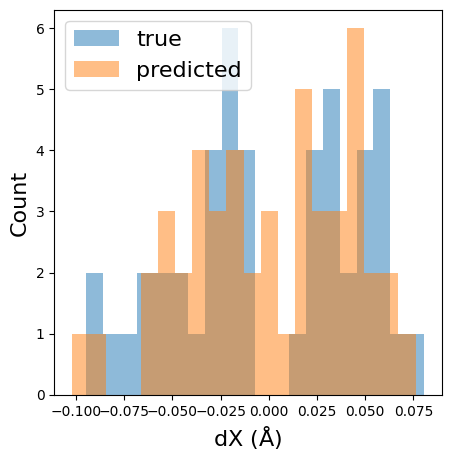

In [13]:
# plot histogram dX_pred vs dX_true
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(dX_true, bins=20, color='tab:blue', alpha=0.5, label='true')
ax.hist(dX_pred, bins=20, color='tab:orange', alpha=0.5, label='predicted')
fsize = 16
ax.set_xlabel(r'dX ($\mathrm{\AA}$)', fontsize=fsize)
ax.set_ylabel('Count', fontsize=fsize)
ax.legend(fontsize=fsize)
plt.show()
